## Introduction
The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492** frauds out of **284,807** transactions. The dataset is **highly unbalanced**, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

Features **V1, V2, ... V28** are the principal components obtained with PCA;
The only features which have not been transformed with PCA are Time and Amount. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.

Feature **Class** is the response variable and it takes value 1 in case of fraud and 0 otherwise

In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the data
data = pd.read_csv('creditcard.csv')
#Preview of the first few rows
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#shape of the data
print("The dataset contains, number of rows:",data.shape[0] ,  "number of columns:" , data.shape[1])

The dataset contains, number of rows: 284807 number of columns: 31


In [4]:
#General structure and information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
#Descriptive statistics of the dataset
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Data Preparation

#### Missing Values

In [6]:
#check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    if missing_values.sum() == 0:
        return "No missing values found."
    else:
        missing_percent = round(missing_values/len(df)*100,2)
        missing_values = pd.concat([missing_values, missing_percent], axis=1, keys=['Number of Missing Values', 'Percentage of Missing Values'])
        return missing_values

In [7]:
check_missing_values(data)

'No missing values found.'

In [8]:
class_counts = data['Class'].value_counts()
class_counts

0    284315
1       492
Name: Class, dtype: int64

#### Class Imbalance

In [9]:
# Count the number of occurrences of each value in the "Class" column
class_counts = data.groupby("Class").size()

# Create a bar chart of the value counts using Plotly
fig = go.Figure(
    data=[go.Bar(x=class_counts.index, y=class_counts.values)],
    layout=go.Layout(title="Class Distribution", xaxis=dict(tickvals=[0, 1],title = 'Class', ticktext=["Fraud", "Not Fraud"]), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600)
)

# Show the chart
fig.show()

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

## Data Exploration

#### Transactions in Time

In [10]:
fraud = data[data['Class'] == 1]
not_fraud = data[data['Class'] == 0]

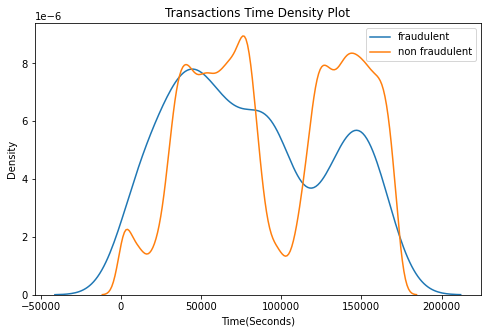

In [11]:
plt.figure(figsize=(8,5))
ax = sns.distplot(fraud['Time'],label='fraudulent',hist=False)
ax = sns.distplot(not_fraud['Time'],label='non fraudulent',hist=False)
ax.set(xlabel='Time(Seconds)', title = 'Transactions Time Density Plot')

# Show the plot
plt.legend()
plt.show()

There seems to be no clear pattern or trend in the occurrence of fraudulent transactions over time. The distribution of fraudulent transactions appears to be random and sporadic, without any significant spikes or dips in frequency over time.

In [12]:
data['Hour'] = data['Time'].apply(lambda x: np.floor(x/3600))
tmp = data.groupby(['Hour','Class'])['Amount'].aggregate(['min','max','sum','mean','median','count']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median
0,0.0,0,0.0,7712.43,256572.87,64.774772,12.990,3961
1,0.0,1,0.0,529.00,529.00,264.500000,264.500,2
2,1.0,0,0.0,1769.69,145806.76,65.826980,22.820,2215
3,1.0,1,59.0,239.93,298.93,149.465000,149.465,2
4,2.0,0,0.0,4002.88,106989.39,68.803466,17.900,1555


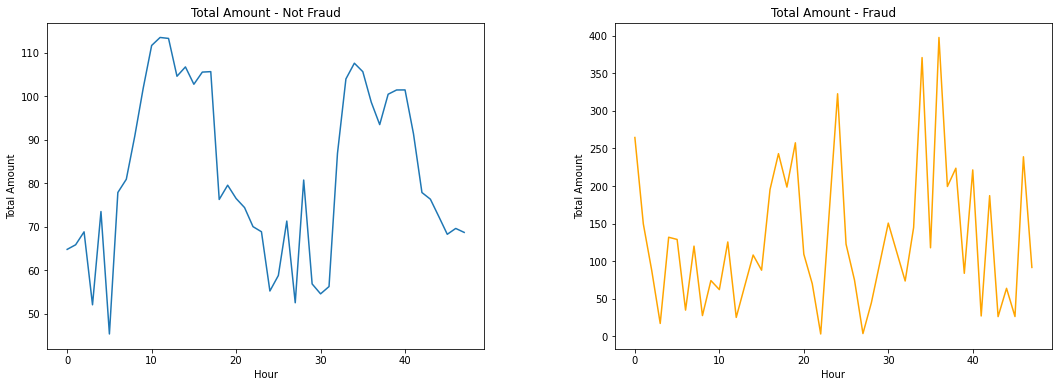

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(18,6))

# plot lineplot for fraud data
sns.lineplot(x='Hour', y='Sum', data=df.loc[df.Class== 0], ax=axs[0])
axs[0].set(title = 'Total Amount - Not Fraud',xlabel= 'Hour', ylabel='Total Amount')

# plot lineplot for not fraud data
sns.lineplot(x='Hour', y='Sum', data=df.loc[df.Class==1], color='orange', ax=axs[1])
axs[1].set(title = 'Total Amount - Fraud',xlabel= 'Hour', ylabel='Total Amount')


# adjust space between subplots
plt.subplots_adjust(wspace=0.3)

# display the plots
plt.show()

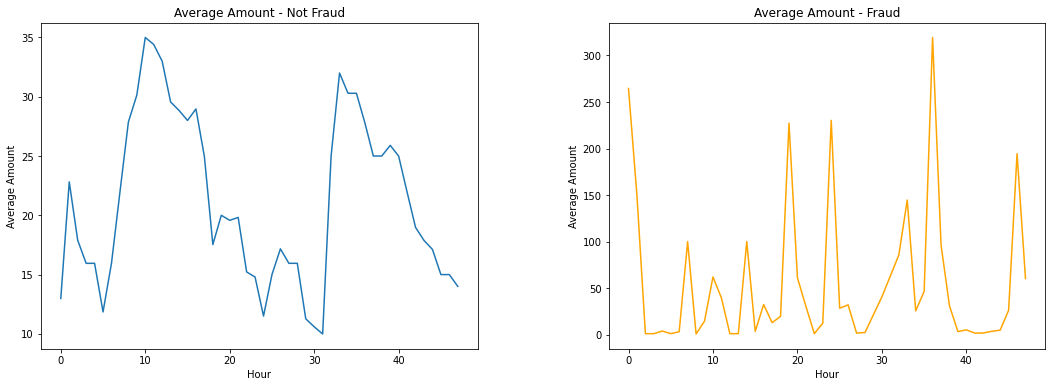

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(18,6))

# plot lineplot for fraud data
sns.lineplot(x='Hour', y='Mean', data=df.loc[df.Class== 0], ax=axs[0])
axs[0].set(title = 'Average Amount - Not Fraud',xlabel= 'Hour', ylabel='Average Amount')

# plot lineplot for not fraud data
sns.lineplot(x='Hour', y='Mean', data=df.loc[df.Class==1], color='orange', ax=axs[1])
axs[1].set(title = 'Average Amount - Fraud',xlabel= 'Hour', ylabel='Average Amount')


# adjust space between subplots
plt.subplots_adjust(wspace=0.3)

# display the plots
plt.show()

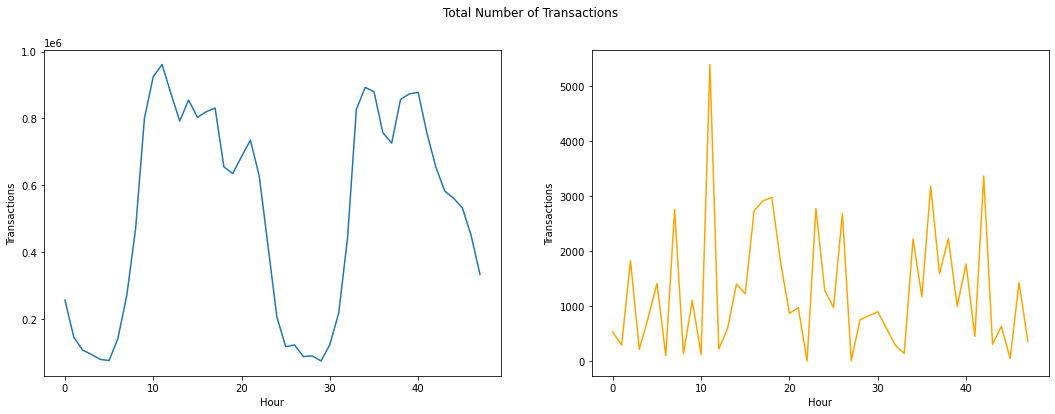

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class== 1], color="orange")
plt.suptitle("Total Number of Transactions")
plt.show();

### Features Correlation

<AxesSubplot:>

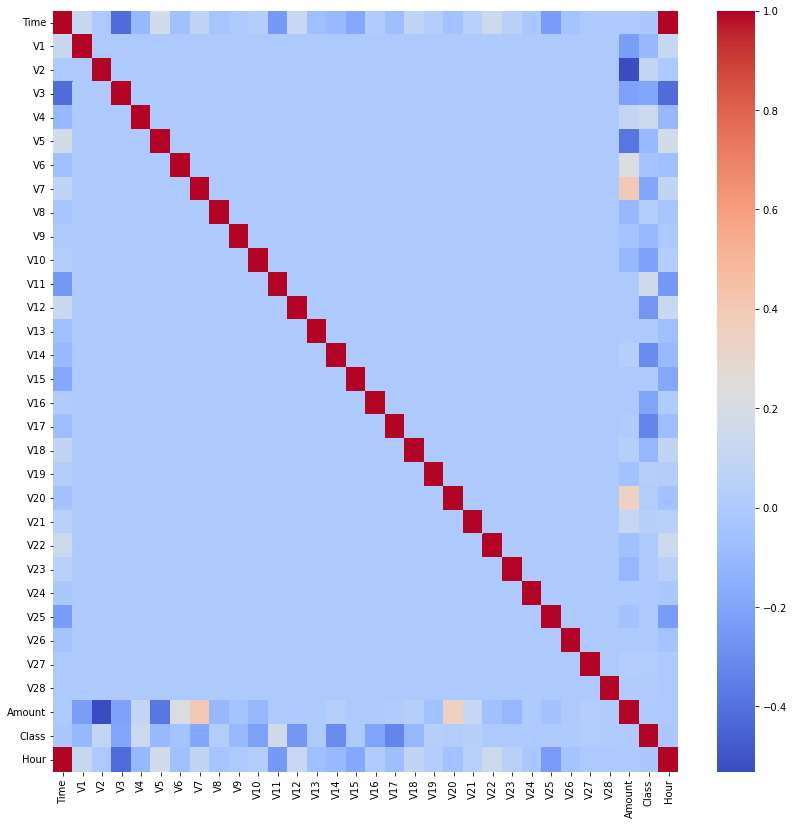

In [16]:
corr = data.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(14,14))

sns.heatmap(corr, cmap='coolwarm')

> There is a weak correlation between the features in the dataset, which means that they are not strongly predictive of each other.

### Features Density plot

<Figure size 432x288 with 0 Axes>

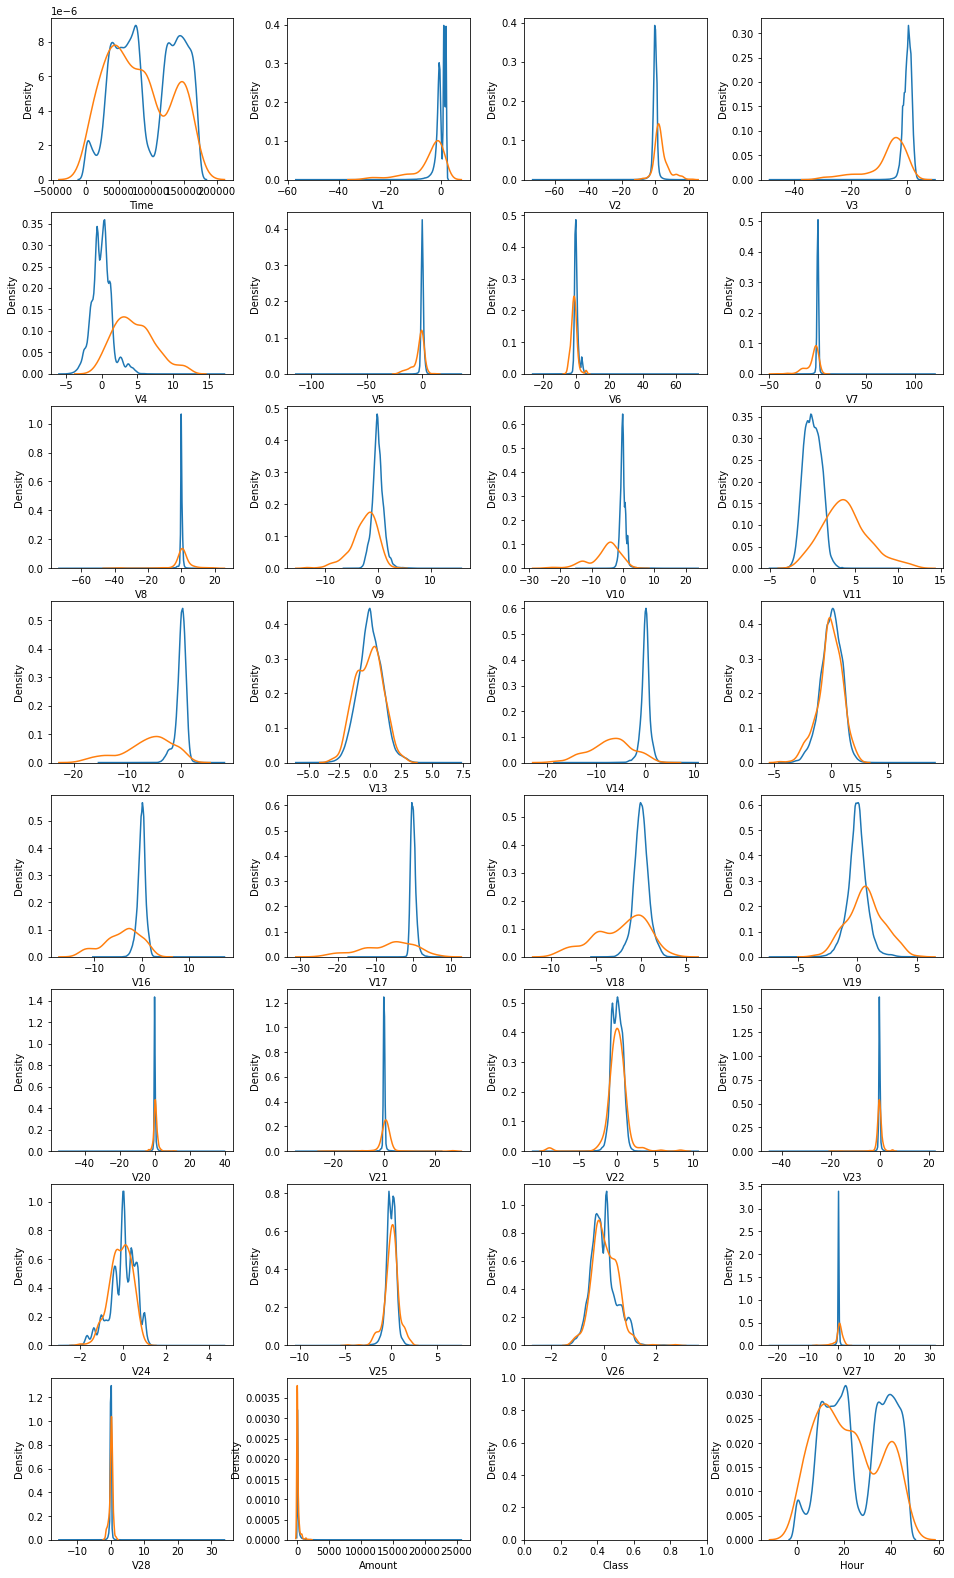

In [17]:
X = data.columns.values

i = 0
t0 = data.loc[data['Class'] == 0]
t1 = data.loc[data['Class'] == 1]

plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in X:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature],label="Class = 0")
    sns.kdeplot(t1[feature],label="Class = 1")
    plt.xlabel(feature)
# adjust space between subplots
plt.subplots_adjust(wspace=0.3)

plt.show();

> We see that there are many variables, which are heavily skewed

## Predictive Models 

#### Define Target variable and Predictor variables
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [18]:
y = data['Class']
X =  data.drop(['Class'], axis=1)

#### Split Data into Train, Validation and Test sets

In [19]:
from sklearn.model_selection import train_test_split

#split the data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=2018)

#split the data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=2018)

### Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])

X_train.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
64434,51145.0,-0.898731,-0.064732,1.184601,0.196442,2.435108,4.041210,-0.932042,1.237936,-0.058540,...,-0.008669,-0.154526,-0.191093,1.008195,0.387983,-0.212567,0.120716,0.099688,-0.309108,14.0
164469,116737.0,1.128220,-1.701569,-0.892817,0.501977,-0.503090,0.880431,-0.268431,0.254330,1.373592,...,0.538263,0.991945,-0.118235,-1.020177,-0.440175,-0.503295,0.039319,0.021074,1.159514,32.0
256083,157531.0,1.953158,-0.532874,-0.044464,0.619915,-1.195339,-0.880123,-0.726678,-0.015986,1.429566,...,0.175710,0.664667,0.230608,0.483426,-0.381663,0.544380,-0.027181,-0.044800,-0.303177,43.0
217751,141018.0,-1.024344,0.830423,-1.837306,1.455775,0.399188,-0.898847,2.087792,-0.376099,-1.753964,...,0.346767,1.082240,-0.464619,1.246238,0.297855,1.264712,0.054034,-0.139152,0.738544,39.0
166836,118338.0,1.936193,0.178625,-1.432951,1.032515,0.611245,-0.430855,0.412651,-0.176755,-0.301373,...,-0.045645,-0.172600,0.219719,0.668324,0.030872,-0.865427,-0.013367,-0.044745,-0.214795,32.0


### Modeling on Imbalanced Data

#### Metric Selection
 As we have seen, we are dealing with heavily imbalanced data. With only 0.172% of the transactions being fraudulent, accuracy  can be a misleading metric for evaluating model performance as it can be heavily biased towards the majority class.
 
Hence, we'll use ROC AUC, which takes into account both true positive rate (TPR) and false positive rate (FPR) and provides a single score that measures the overall performance of the model in detecting both classes. A perfect model would have an ROC AUC score of 1, while a random model would have an ROC AUC score of 0.5. By using ROC AUC score, we can evaluate the model's ability to correctly classify both legitimate and fraudulent transactions, and it is a more appropriate metric for imbalanced datasets.

#### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# define the logistic regression model
lr = LogisticRegression(random_state=42)

In [22]:
# define the hyperparameter search space
param_distributions = {
    'C': [0.1, 1, 10,100,100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

# perform randomized search cross-validation to find the best set of hyperparameters
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=param_distributions,
                               n_iter=10, cv=5, scoring='roc_auc', random_state=42)
lr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.1, 1, 10, 100, 100],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='roc_auc')

In [23]:
# get the best set of hyperparameters
lr_best = LogisticRegression(**lr_random.best_params_, random_state=42)
lr_best.fit(X_train, y_train)

#score on the validation set
y_val_pred_lr = lr_best.predict_proba(X_val)[:, 1]
roc_auc_lr_val = roc_auc_score(y_val, y_val_pred_lr)

In [24]:
# score on the test set
y_test_pred_lr = lr_best.predict_proba(X_test)[:, 1]
roc_auc_lr_test = roc_auc_score(y_test, y_test_pred_lr)

print('Best set of hyperparameters:', lr_random.best_params_)
print('Validation ROC AUC:', roc_auc_lr_val)
print('Test ROC AUC:', roc_auc_lr_test)

Best set of hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Validation ROC AUC: 0.9792062073031205
Test ROC AUC: 0.9773296753543667


The best set of hyperparameters that were found during the model training using grid search was {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}. This means that the logistic regression model performed the best with the 'liblinear' solver, 'l1' penalty, and a regularization parameter of 0.1.

To evaluate the performance of the model, we used the ROC AUC metric. ROC AUC is a more appropriate metric than accuracy in the case of imbalanced datasets like credit card fraud detection. The validation ROC AUC score of the logistic regression model was 0.979, which indicates that the model has good predictive power. The test ROC AUC score of the logistic regression model was 0.977, which suggests that the model is performing well on unseen data as well. Overall, the logistic regression model with the chosen hyperparameters seems to be a good fit for the credit card fraud detection task.

#### Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

# define the random forest classifier
rf = RandomForestClassifier(random_state=42)

In [26]:
# define the hyperparameter search space
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# perform randomized search cross-validation to find the best set of hyperparameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                               n_iter=10, cv=5, scoring='roc_auc', random_state=42)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='roc_auc')

In [27]:
# get the best set of hyperparameters and score on the validation set
rf_best = RandomForestClassifier(**rf_random.best_params_, random_state=42)
rf_best.fit(X_train, y_train)
y_val_pred_rf = rf_best.predict_proba(X_val)[:, 1]
roc_auc_rf_val = roc_auc_score(y_val, y_val_pred_rf)


In [28]:
# score on the test set
y_test_pred_rf = rf_best.predict_proba(X_test)[:, 1]
roc_auc_rf_test = roc_auc_score(y_test, y_test_pred_rf)

print('Best set of hyperparameters:', rf_random.best_params_)
print('Validation ROC AUC:', roc_auc_rf_val)
print('Test ROC AUC:', roc_auc_rf_test)

Best set of hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Validation ROC AUC: 0.96351631025648
Test ROC AUC: 0.9620687805564349


### Decision Tree Classifier

In [35]:
# define the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

In [36]:

# define the hyperparameter search space
param_distributions = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# perform randomized search cross-validation to find the best set of hyperparameters
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_distributions,
                               n_iter=10, cv=5, scoring='roc_auc', random_state=42)
dt_random.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='roc_auc')

In [37]:
# get the best set of hyperparameters and score on the validation set
dt_best = DecisionTreeClassifier(**dt_random.best_params_, random_state=42)
dt_best.fit(X_train, y_train)
y_val_pred_dt = dt_best.predict_proba(X_val)[:, 1]
roc_auc_dt_val = roc_auc_score(y_val, y_val_pred_dt)


In [38]:
# score on the test set
y_test_pred_dt = dt_best.predict_proba(X_test)[:, 1]
roc_auc_dt_test = roc_auc_score(y_test, y_test_pred_dt)

print('Best set of hyperparameters:', dt_random.best_params_)
print('Validation ROC AUC:', roc_auc_dt_val)
print('Test ROC AUC:', roc_auc_dt_test)

Best set of hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Validation ROC AUC: 0.8575713391785553
Test ROC AUC: 0.8797751573986141


### XG Boost Classifier

In [31]:
# define the XGBoost classifier
xgb = XGBClassifier(random_state=42)

In [32]:
# define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'n_estimators': [100, 200, 300]
}

# perform randomized search cross-validation to find the best set of hyperparameters
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42)
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                   

In [33]:
# get the best set of hyperparameters and score on the validation set
xgb_best = XGBClassifier(**xgb_random.best_params_, random_state=42)
xgb_best.fit(X_train, y_train)
y_val_pred_xgb = xgb_best.predict_proba(X_val)[:, 1]
roc_auc_xgb_val = roc_auc_score(y_val, y_val_pred_xgb)


In [34]:
# score on the test set
y_test_pred_xgb = xgb_best.predict_proba(X_test)[:, 1]
roc_auc_xgb_test = roc_auc_score(y_test, y_test_pred_xgb)

print('Best set of hyperparameters:', xgb_random.best_params_)
print('Validation ROC AUC:', roc_auc_xgb_val)
print('Test ROC AUC:', roc_auc_xgb_test)


Best set of hyperparameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Validation ROC AUC: 0.9657540892618952
Test ROC AUC: 0.971727339875488
